# Gaussian Processes: priors

## Nonparamteric models

So far in this course, all the models we have built were regressions, working in the supervised learning setting and using parametric models. We tried to describe functions with unknown parameters using Bayesian formalism.

Today we will introduce nonparametric models. The term <font color='orange'>nonparametric</font> means that the shape of the functions is determined by the data as opposed to parametric functions which are defined by a typically fixed set of parameters. In nonparametric models <font color='orange'>the number of parameters grows with the number of data points</font>. Nonparametric functions are extremely flexible since their shape adapts to the underlying patterns in the data.

```{margin}
Throughout this course it is safe to assume that $\mathcal{X} \in \mathbb{R}^d$.
```
Nonparametric models are commonly based on kernel functions. A  <font color='orange'>kernel function</font> $k(x, x′)$ is a map of a pair of inputs $x$ and $x′ \in \mathcal{X}$ with input domain $\mathcal{X}$ into real numbers 

$$
k: (x, x') \to \mathbb{R}, \quad x, x' \in \mathcal{X}
$$

<font color='orange'>characterizing the similarity</font> of the pair of inputs $x, x'$. 

## Gaussian processes - preview

Gaussian processes (GPs) are an example of nonparametric models. They are powerful and flexible statistical models commonly used in GLMMs as random effects where they act as <font color='orange'>latent variable</font>.

A GP can be defined as a collection of random variables, any <font color='orange'>finite subset</font> of which has a <font color='orange'>joint multivariate normal</font> distribution typically represented as 

$$
f(x) \sim \mathcal{GP}(\mu(x), k(x, x')) 
$$ 

where $\mu(x) $ is the <font color='orange'>mean function</font> and $ k(x, x') $ is the <font color='orange'>covariance function</font>.

A GP defines a <font color='orange'>distribution over functions</font> rather than individual points.


```{margin}
Well, we do assume *something* about the functions, e.g. their smoothness in the form of kernel choice.
```
GPs can model a wide variety of functions without assuming a specific functional form. This makes them particularly useful when dealing with complex or unknown relationships in data.

GPs are inherently Bayesian models, meaning they provide a principled way to quantify uncertainty in predictions. This is achieved by representing the posterior distribution over functions given the observed data.

The choice of kernel function determines the behavior and characteristics of the GP. Common kernel functions include the radial basis function (RBF), also known as the squared exponential kernel, and the Matérn kernel, among others. These kernels encode assumptions about the smoothness and structure of the underlying function. We will see specific examples of kernels in this lecture.

While GPs offer many advantages, they can be <font color='orange'>computationally intensive</font>, especially as the size of the dataset grows. Various approximation methods such as sparse GPs and approximate inference techniques are used to scale Gaussian processes to larger datasets.

This was a preview. We will return to the formal definition once again later in this lecture.

Now let's build the inredients which we need to understand Gaussian processes step by step.

## From Univariate to Multivariate Gaussians

### Univariate Normal distribution
```{margin}
In the chapter about distributions we used notation $X$ for a random variable and $x$ for its values. Here we will use $y$ instead. It will soom become clear soon why we need to switch, and why we need to reserve $x$ for something else.
```

Recall from previous chapters, the univaritae normal distribution has PDF

$$
\mathcal{N}(y \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y - \mu)^2}{2\sigma^2}\right).
$$

As before, the notation here will be $y \sim \mathcal{N}(\mu, \sigma^2)$,

### Reparametrization

Note, that in order to sample variable $y$ we could first sample a standard Normal variable $z \sim \mathcal{N}(0,1)$, and then perform a transformation of this variable 

$$
y = \mu + \sigma z \sim \mathcal{N}(\mu, \sigma^2).
$$

`````{admonition} Group Task 
:class: tip

Prove that $y:= \mu + \sigma z$ is indeed distributed as $\mathcal{N}(\mu, \sigma^2).$ 

Hint: What you need to show for that is that $\mathbb{E}[y] = \mu$ and $\text{Var}[y] = \sigma^2$. To conclude, make an argument about why $y$ is normally distributed.

`````

### Multivariate Normal distribution

In the multivariate case, instead of using scalar mean and variance parameters $\mu, \sigma^2 \in \mathbb{R}$, we need to specify a vector mean $\mu \in \mathbb{R}^d$ and covariance matrix $K \in \mathbb{R}^{d \times d}.$ To write that variable $y$ follows a multivariate mormal distribution, we use notation 

$$
y \sim \mathcal{N}(\mu, K).
$$


### Bivariate case

'Bivariate' means $d=2$. Hence,

$$
y =  \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}, \quad \mu = \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \quad K = \begin{bmatrix} \sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2  &\sigma_2^2 \end{bmatrix}.
$$

Here $\mu_i$ is the mean of component $y_i$, $\sigma_i^2$ is the variance for the $i$-th dimension, and $\rho_{ij} = \rho_{ji}$ is the *correlation* between the $i$-th and $j$-th dimensions:

$$
\begin{align*}
\mathbb{E}(y_i) = \mu_i,\\
\text{var}(y_i) = \sigma_i^2,\\
\text{corr}(y_1, y_2) = \rho_{12}.
\end{align*}
$$
The covariance matrix tells us how the "ball" of random variables is stretched and rotated in space. Let's visualise a few examples.


In [1]:
import numpy as np
#from scipy.stats import norm

import jax.numpy as jnp
from jax import jit

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.gridspec as gridspec

import numpyro.distributions as dist


/opt/anaconda3/envs/aims/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


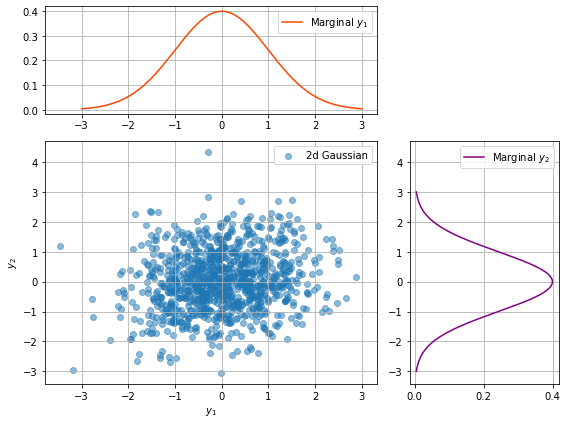

In [2]:
def plot_2d_gp(mu1, mu2, rho=0, sigma1=1, sigma2=1):
    
    # Generate data points from the 2D Gaussian distribution

    mu = np.array([mu1, mu2])  
    covariance = jnp.array([[sigma1**2, rho*sigma1*sigma2],[rho*sigma1*sigma2, sigma2**2]]) 
    
    num_samples = 1000
    data = np.random.multivariate_normal(mu, covariance, num_samples)

    # Calculate marginal distributions
    y_values = np.linspace(-3, 3, 1000)

    normal1  = dist.Normal(loc= mu[0], scale =np.sqrt(covariance[0, 0]))
    normal2  = dist.Normal(loc= mu[1], scale =np.sqrt(covariance[1, 1]))
                         
    marginal_y1 = jnp.exp(normal1.log_prob(y_values))
    marginal_y2 = jnp.exp(normal1.log_prob(y_values))

    # Create figure 
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(3, 3)

    # Main plot (2D Gaussian distribution)
    ax_main = fig.add_subplot(gs[1:3, :2])
    ax_main.scatter(data[:, 0], data[:, 1], alpha=0.5, label='2d Gaussian')
    ax_main.set_xlabel('$y_1$')
    ax_main.set_ylabel('$y_2$')
    ax_main.legend()
    ax_main.grid(True)

    # Marginal X plot
    ax_marginal_x = fig.add_subplot(gs[0, :2], sharex=ax_main)
    ax_marginal_x.plot(y_values, marginal_y1, label='Marginal $y_1$', color='orangered')
    ax_marginal_x.legend()
    ax_marginal_x.grid(True)

    # Marginal Y plot
    ax_marginal_y = fig.add_subplot(gs[1:3, 2], sharey=ax_main)
    ax_marginal_y.plot(marginal_y2, y_values, label='Marginal $y_2$', color='purple')
    ax_marginal_y.legend()
    ax_marginal_y.grid(True)

    plt.tight_layout()
    plt.show()

# Parameters for the 2D Gaussian distribution
mu1 = 0
mu2 = 0
rho = 0.1

plot_2d_gp(mu1, mu2, rho)

`````{admonition} Group Task 
:class: tip

Loop over several values of $\rho$. How does the distribution change?

`````

### $d>2$

```{margin}
This great visualisation idea I borrowed from Darren Wilkinson's slides from the Gaussian Process Summer School.
```

Visualising the distribution in dimensions higher than 2 is harder. 

Still, in 2d we can use indices of components of $y$: 1 for $y_1$ and 2 for $y_2$ to make the plots. 

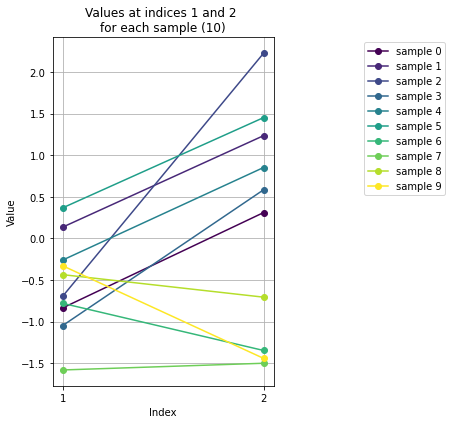

In [3]:
# Parameters for the 2D Gaussian distribution
mu = np.array([0, 0])  # mean
covariance = np.array([[1, 0.5], [0.5, 1]])  # covariance matrix

num_samples = 10
data = np.random.multivariate_normal(mu, covariance, num_samples)

# Extract values at indices 1 and 2 for each sample
index_1 = 1
index_2 = 2
values_1 = data[:, index_1 - 1]
values_2 = data[:, index_2 - 1]

# Generate a color map
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=num_samples - 1)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Plotting
plt.figure(figsize=(4, 6))

for i in range(num_samples):
    color = scalar_map.to_rgba(i)
    plt.plot([1, 2], [values_1[i], values_2[i]], color=color, marker='o', linestyle='-', label=f'sample {i}')

plt.xticks([1, 2], ['1', '2'])  # Set x-axis ticks to only 1 and 2
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Values at indices 1 and 2 \nfor each sample ({num_samples})')
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))
plt.grid(True)
plt.show()


Can we generalise this approach to visualise data of higher dimensionality $d$?

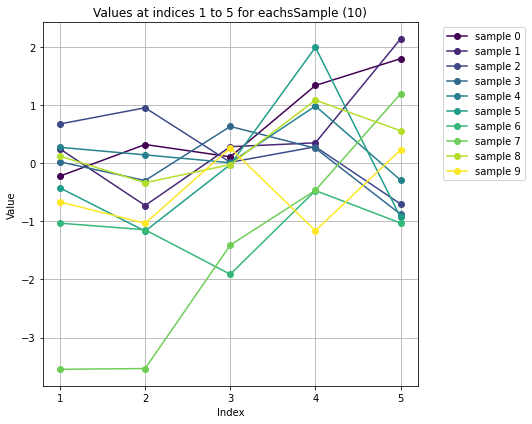

In [4]:
def plot_values(data, d):
    num_samples = data.shape[0]
    indices = list(range(1, d + 1))  # Indices to plot
    values = [data[:, idx - 1] for idx in indices]

    # Generate a color map
    cmap = plt.get_cmap('viridis')
    norm = Normalize(vmin=0, vmax=num_samples - 1)
    scalar_map = ScalarMappable(norm=norm, cmap=cmap)

    # Plotting
    plt.figure(figsize=(6, 6))

    for i in range(num_samples):
        color = scalar_map.to_rgba(i)
        plt.plot(indices, [values[j][i] for j in range(len(indices))], color=color, marker='o', linestyle='-', label=f'sample {i}')

    plt.xticks(indices, [str(idx) for idx in indices])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Values at indices 1 to {d} for eachsSample ({num_samples})')
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.show()

# Parameters for the multivariate Gaussian distribution
# mean vector
mu = np.zeros(5)  

# covariance matrix
covariance = np.array([[1,    0.8,  0.7, 0.4, 0.1],
                       [0.8,    1,  0.5, 0.3, 0.2],
                       [0.7,   0.5,    1, 0.2, 0.1],
                       [0.4,   0.3,  0.2,   1, 0.1],
                       [0.1,   0.2,  0.1, 0.1,   1]])  

# generate data from multivariate normal distribution

# Number of components in the vector
d = 5  

# number fo samples
num_samples = 10
data = np.random.multivariate_normal(mu, covariance, num_samples)
plot_values(data, d)


In the example above we coded up the covariance matris by hand. It is time to look into what covariance matrices might be more meaningful.

## Gaussian process - revisiting the definition

Let's revisit what a Gaussian process is. 

A <font color='orange'>stochastic process</font> is a collection of random variables $f=f(x)$ indexed by some variable $x \in \mathcal{X}$.

A Gaussian process is a stochastic process $f: \mathcal{X} \to \mathbb{R}$, such that its every finite realisation $ [f(x_1), ..., f(x_d)]^T$ follows a multivariate normal dsitribution

$$
\begin{bmatrix} f(x_1) \\ ... \\ f(x_d) \end{bmatrix} \sim \mathcal{N}\left( \underbrace{\begin{bmatrix} \mu(x_1) \\ ... \\ \mu(x_d) \end{bmatrix}}_{\mu}, 
\underbrace{\begin{bmatrix}  k(x_1, x_1) \quad k(x_1, x_2) \quad... \quad k(x_1, x_d)  \\ ... \\ k(x_d, x_1)\quad k(x_d, x_2) \quad... \quad k(x_d, x_d) \end{bmatrix}}_{\Sigma}
\right).
$$

Hence, a Gaussian process is fully specified by its mean and covariance functions $\mu(x), k(x,x'):$

$$f(x) \sim \mathcal{GP}(\mu(x), k(x, x')),$$

where

$$\mathbb{E}[f(x)]=\mu(x)$$

and 

$$\text{cov}[f(x), f(x')]=k(x, x').$$

Typically, for the mean function we chose one of the following options $\mu(x)=0,  \mu(x)=c, \mu(x)=\beta^Tx$.

## Kernels

Covariance function must be a positive semi-definite function in order to lead to valid covariance matrices.

A kernel $k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ is positive semi-definite, if for any finite collection $x= (x_1, ..., x_d)$ the matrix $k_{xx}$ with $[k_{xx}]_{ij}=k(x_i, x_j)$ is positive semi-definite.

A symmetric matrix $A \in \mathbb{R}^{N \times N}$ is called <font color='orange'>positve semi-definite</font> if

$$
v^T A v \ge 0
$$ 

for any $v \in \mathbb{R}^d.$

Kernel functions $k(x, x′)$ encode our prior beliefs about data-generating latent functions. These typically include continuity, smomothness (differentialbility),periodicity, stationarity, and so on.

Covariance functions typically have <font color='orange'>hyperparameters</font> that we aim to learn from data.

Let us explore some typical covariance functions.

### Radial basis function (RBF)

The squared exponential kernel, also known as the Gaussian kernel or the radial basis function (RBF) kernel is one of the most commonly used kernels in Gaussian processes due to its smoothness. It is defined as

$$k(x_i, x_j) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \|x_i - x_j\|^2 \right)$$

where $\sigma^2$ is the <font color='orange'>variance parameter</font> (also called the amplitude), $l$ is the <font color='orange'>lengthscale</font> parameter and $\|x_i - x_j\|$ is the Euclidean distance between the points $x_i$ and $x_j$.

This kernel assigns high similarity (and hence high covariance) to points that are close to each other in the input space and low similarity (and low covariance) to points that are far apart. The parameters $\sigma^2$ and $l$ control the overall variance and the rate at which the covariance decreases with distance, respectively.



In [5]:
def rbf_kernel(x1, x2, sigma=1.0, lengthscale=1.0, jitter=1e-6):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - jitter (float): Small positive value added to the diagonal elements.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)

    # Add jitter to ensure positive definiteness. This is a purely numeric trick
    K += jitter * jnp.eye(K.shape[0])  
    return K

Let us visualise several samples of the GP with RBF kernel with a fixed lengthscale:

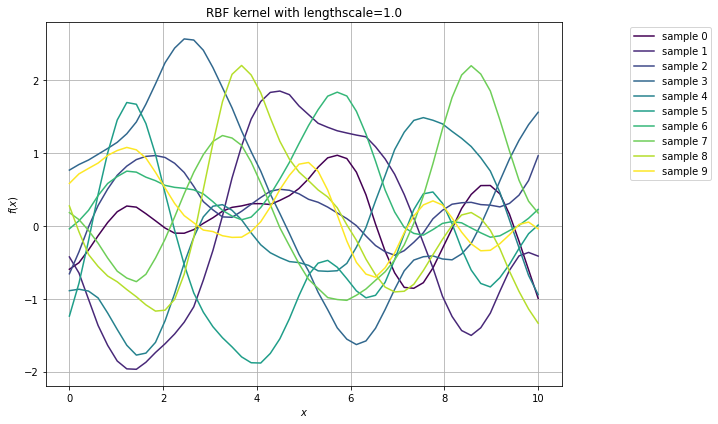

In [6]:
# Define parameters
n_points = 50
num_samples = 10
sigma = 1.0
lengthscale = 1.0
jitter = 1e-4

# Generate random input data
x = jnp.linspace(0, 10, n_points).reshape(-1, 1)

# Compute covariance matrix using RBF kernel function
K = rbf_kernel(x, x, sigma=sigma, lengthscale=lengthscale, jitter=jitter)

# Generate a color map
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=num_samples - 1)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# Parameters for the multivariate Gaussian distribution
mu = np.zeros(n_points)  # mean vector

data = np.random.multivariate_normal(mu, K, num_samples)


# Plotting
plt.figure(figsize=(8, 6))

for i in range(num_samples):
    color = scalar_map.to_rgba(i)
    plt.plot(x, data[i,:], linestyle='-', color=color, label=f'sample {i}')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title(f'RBF kernel with lengthscale={lengthscale}')
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

How do curves with different lengthscales look like?

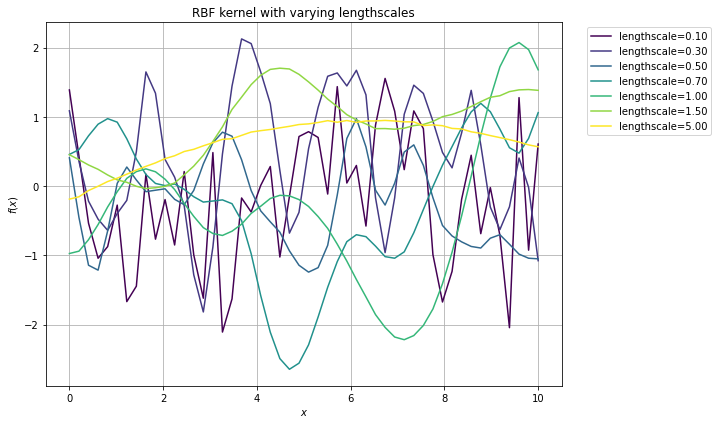

In [7]:
# Generate random lengthscale values for each sample
#lengthscales = np.linspace(0.2, 4, 8)
lengthscales = np.array([0.1, 0.3,  0.5, 0.7, 1.0, 1.5, 5.0])

# Plotting
plt.figure(figsize=(8, 6))

for i, lengthscale in enumerate(lengthscales):

    # Compute covariance matrix using RBF kernel function with different lengthscale for each sample
    K = rbf_kernel(x, x, sigma=sigma, lengthscale=lengthscale, jitter=jitter)

    # Draw samples from multivariate Gaussian distribution
    mu = np.zeros(n_points)  
    data = np.random.multivariate_normal(mu, K)
    
    # Generate a color corresponding to the lengthscale
    color = cmap(i / (len(lengthscales) - 1))
    
    # Plot the sample
    plt.plot(x, data, linestyle='-', color=color, label=f'lengthscale={lengthscale:.2f}')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title(f'RBF kernel with varying lengthscales')
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


`````{admonition} Group Task 
:class: tip

How can you describe this dependence of the trajectories on the lengthscale?

`````

`````{admonition} Group Task 
:class: tip

Explore [this](http://www.infinitecuriosity.org/vizgp/) interactive visualisation.


`````

Apart from visualising trajectories, we can also plot the covariance matrix:

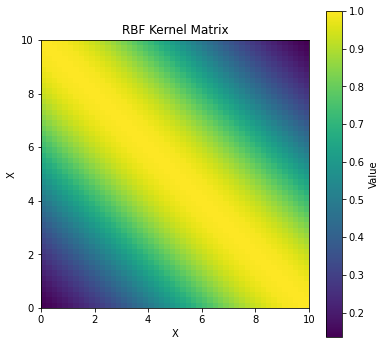

In [8]:
# Visualization
plt.figure(figsize=(6, 6))
plt.imshow(K, cmap='viridis', extent=[0, 10, 0, 10])
plt.colorbar(label='Value')
plt.title('RBF Kernel Matrix')
plt.xlabel('X')
plt.ylabel('X')
plt.show()


We will need to plot many more GP trajectories. Let's make a wrapper:

In [9]:
def plot_gp_samples(x, K, ttl="", num_samples=5):
    
    num_points = len(x)
    samples = np.random.multivariate_normal(mean=np.zeros(num_points), cov=K, size=num_samples)

    # Plot the samples
    plt.figure(figsize=(8, 6))
    for i in range(num_samples):
        color = cmap(i / (len(lengthscales) - 1))
        plt.plot(x, samples[i], label=f'Sample {i}', color=color)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.show()

## test the function
#n_points = 50
#sigma = 1.0
#lengthscale = 1.0
#jitter = 1e-4

## Generate random input data
#x = jnp.linspace(0, 10, n_points).reshape(-1, 1)

## Compute covariance matrix using RBF kernel function
#K = rbf_kernel(x, x, sigma=sigma, lengthscale=lengthscale, jitter=jitter)

#plot_gp_samples(x, K, ttl="RBF kernel demonstration")

### Matérn kernels

The Matérn kernel is another popular choice in Gaussian processes. It is a flexible covariance function that is able to capture <font color='orange'>different levels of smoothness</font> in the data. The Matérn kernel is defined as:

$$
k_{\text{Matérn}}(x_i, x_j) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \frac{\sqrt{2\nu}}{\ell} \|x_i - x_j\| \right)^\nu K_\nu \left( \frac{\sqrt{2\nu}}{\ell} \|x_i - x_j\| \right)
$$

where $k(x_i, x_j)$ represents the covariance between two data points $x_i$, $x_j$, $\sigma^2$ is the variance parameter, $\nu$ is the smoothness parameter, typically a positive half-integer ($\nu = 1/2, 3/2, 5/2$), $l$ is the length-scale parameter, $\|x_i - x_j\|$ is the Euclidean distance between the points $x_i$ and $x_j$, $K_\nu$ is the modified Bessel function of the second kind of order $\nu$, $\Gamma$ is the gamma function.


### Matérn 3/2 and 5/2

The Matérn kernel with $\nu=3/2$ is a particular case of the Matérn family of kernels and is defined as

$$k_{\text{Matérn-3/2}}(x_i, x_j) = \sigma^2 \left(1 + \frac{\sqrt{3} \|x_i - x_j\|}{\ell}\right) \exp\left(-\frac{\sqrt{3} \|x_i - x_j\|}{\ell}\right).$$

The Matérn kernel with $\nu=5/2$ is another member of the Matérn family of kernels. The formula for the Matérn-5/2 kernel is given by

$$k_{\text{Matérn-5/2}}(x_i, x_j) = \sigma^2 \left(1 + \frac{\sqrt{5} \|x_i - x_j\|}{\ell} + \frac{5 \|x_i - x_j\|^2}{3\ell^2}\right) \exp\left(-\frac{\sqrt{5} \|x_i - x_j\|}{\ell}\right).$$



```{margin}
We won't visualise these kernels just yet. Let's definte a couple more options, and then look at the all together.
```

In [10]:
def matern32_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    """
    Compute the Matérn-3/2 kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    arg = dist / lengthscale
    return sigma**2 * (1 + jnp.sqrt(3) * arg) * jnp.exp(- jnp.sqrt(3) * arg)

# Compile the kernel function for better performance
matern32_kernel = jit(matern32_kernel)


In [11]:
def matern52_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    """
    Compute the Matérn-5/2 kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    arg = dist / lengthscale
    return sigma**2 * (1 + jnp.sqrt(5) * arg + 5/3 * arg**2) * jnp.exp(-jnp.sqrt(5) * arg)

# Compile the kernel function for better performance
matern52_kernel = jit(matern52_kernel)


### Periodic kernel

The periodic kernel is commonly used in Gaussian processes to model periodic patterns in data. The formula for the periodic kernel is given as

$$k_{\text{periodic}}(x_i, x_j) = \sigma^2 \exp \left( -\frac{2\sin^2(\pi\|x_i - x_j\|/p)}{\ell^2} \right)$$



In [12]:
def periodic_kernel(x1, x2, sigma=1.0, lengthscale=1.0, period=1.0):
    """
    Compute the periodic kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - period (float): Periodicity parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    return sigma**2 * jnp.exp(-2 * jnp.sin(jnp.pi * dist/ period)**2 / lengthscale**2)

# Compile the kernel function for better performance
periodic_kernel = jit(periodic_kernel)

### Linear kernel

The linear kernel, also known as the dot product kernel, is one of the simplest kernels. It computes the covariance between two data points as the inner product of their feature vectors. The formula for the linear kernel is given as

$$k_{\text{linear}}(x_i, x_j) = \sigma^2 x_i^T x_j$$

In [13]:
def linear_kernel(x1, x2, sigma =1.0):
    """
    Compute the linear kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    return sigma**2 * jnp.dot(x1, x2.T)

# Compile the kernel function for better performance
linear_kernel = jit(linear_kernel)


Now let's sisualise these kernels.

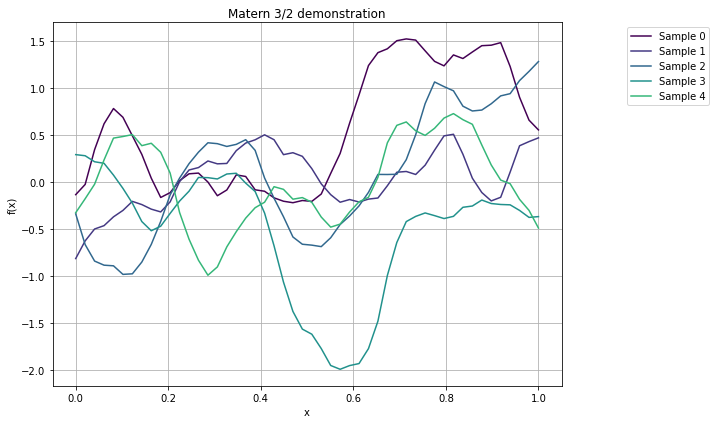

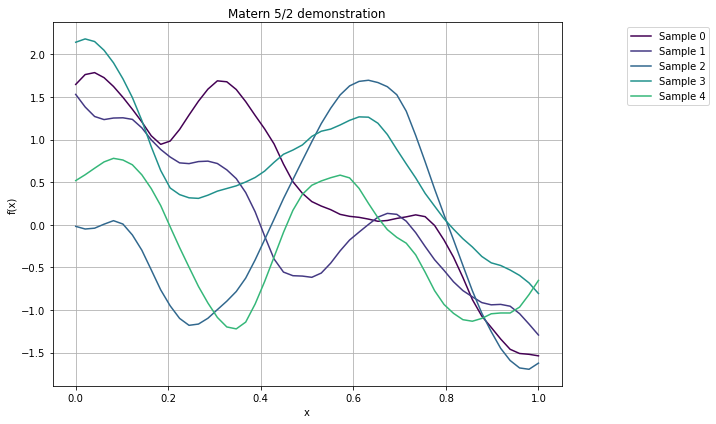

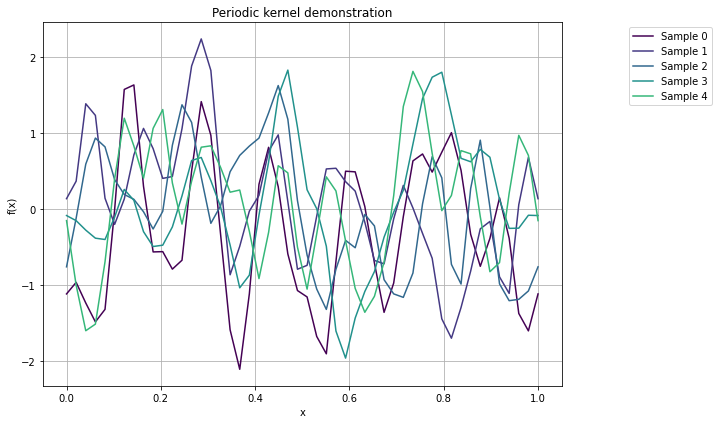

<ipython-input-9-7fb586bb94ec>:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean=np.zeros(num_points), cov=K, size=num_samples)


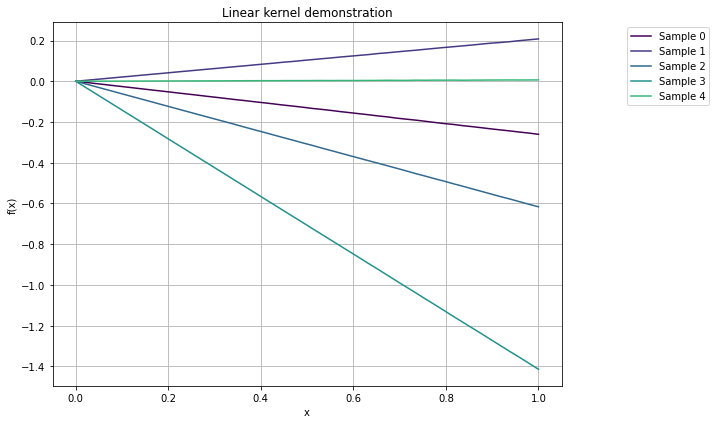

In [14]:
# test the function
n_points = 50
sigma = 1.0
lengthscale = 0.2
jitter = 1e-4

# Generate random input data
x = jnp.linspace(0, 1, n_points).reshape(-1, 1)

# Compute covariance matrix using RBF kernel function
K32 = matern32_kernel(x, x, sigma=sigma, lengthscale=lengthscale)
K52 = matern52_kernel(x, x, sigma=sigma, lengthscale=lengthscale)
K_per = periodic_kernel(x, x, sigma=sigma, lengthscale=lengthscale)
K_lin = linear_kernel(x, x, sigma=sigma)

plot_gp_samples(x, K32, ttl="Matern 3/2 demonstration")
plot_gp_samples(x, K52, ttl="Matern 5/2 demonstration")
plot_gp_samples(x, K_per, ttl="Periodic kernel demonstration")
plot_gp_samples(x, K_lin, ttl="Linear kernel demonstration")

`````{admonition} Task 22
:class: tip

- Implement Matern-1/2 kernel:
    - plot function draws,
    - plot covariance matrix


- Implement the rational quadratic kernel:
    - plot function draws,
    - plot covariance matrix
`````

## Cholesky decomposition and reparametrization

Recall the reparametrization trick for $d=1$. Can we perform a similar computation in $d>1$?

<font color='orange'>Cholesky decomposition</font> is a numerical method used to decompose a positive definite matrix into a lower triangular matrix and its conjugate transpose: for a positive definite matrix $A$ it has the form

$$
A = L L^T
$$

where $L$ is a lower triangular matrix, $L^T$ is the transpose of $L$.

Cholesky decomposition is particularly useful because it provides a computationally efficient way to solve linear systems of equations, including inverting matrices and calculating determinants.

In the Gaussian processes context, Cholesky decomposition is commonly used to generate samples from a multivariate Gaussian distribution. Here we find the Cholesky decomposition of the covariance matrix $K$ which yields a lower triangular matrix $L$:

$$
K = L L^T.
$$

By multiplying this lower triangular matrix with a vector of independent standard normals $z$, we can generate samples from the Gaussian process while ensuring that the resulting samples have the desired covariance structure encoded by the covariance matrix $K$. Hence, we can either sample directly 

$$
f \sim \mathcal{N}(0, \Sigma)
$$

or use the reparametrization

$$
\begin{align*}
z &\sim \mathcal{N}(0,I), \\
f = zL &\sim \mathcal{N}(0, \Sigma).
\end{align*}
$$

`````{admonition} Task 23
:class: tip

Show that $f:= \mu + zL$ is indeed distributed as $\mathcal{N}(\mu, K)$.

`````

## Marginalization and Conditioning

Imagine we have two sets of coordinates $x_n = (x_n^1, x_n^2, ..., x_n^n), x_m = (x_m^1, x_m^2, ..., x_m^m)$ and a GP over them:

$$
\begin{bmatrix} f_n \\ f_m \end{bmatrix} \sim \mathcal{N}\left( \underbrace{\begin{bmatrix} \mu_n \\  \mu_m \end{bmatrix}}_{\mu}, 
\underbrace{\begin{bmatrix}  K_{n n} \quad K_{n m}  \\ K_{m n} \quad K_{m m} \end{bmatrix}}_{K}
\right).
$$

Marginalization allows us to extract partial information from multivariate probability distribution:

$$
\begin{align*}
f_n & \sim \mathcal{N}(\mu_n,  K_{nn}),\\
f_m & \sim \mathcal{N}(\mu_m,  K_{mm}).
\end{align*}
$$

Conditioning allows us to determine the probability of one subset of variables given another subset. Similar to marginalization, this operation is also closed and yields a modified Gaussian distribution:

$$
f_n | f_m \sim \mathcal{N}(\mu_{n|m},  K_{n|m}),
$$

where

$$
\begin{align*}
\mu_{n|m} & = \mu_n + K_{nm} K_{mm}^{-1} (f_m - \mu_m),\\
K_{n|m} & = K_{nn} - K_{nm} K_{mm}^{-1} K_{mn}
\end{align*}
$$

`````{admonition} Group Task 
:class: tip

Write down these formulas for the $d=2$ case, i.e. when both $f_n$ and $f_m$ have only one component each.

`````

Let us visualise such a conditional.

In [15]:
def Gaussian_conditional(mean, cov, x=None,y=None):
  assert not (x is None and y is None) and not (x is not None and y is not None)
  if x is not None:
    var = cov[1,1] -  cov[1,0] * cov[0,0] ** (-1) * cov[0,1]
    mu = mean[1] + cov[1,0] * cov[0,0] ** (-1) * (x - mean[0])
  else:
    var = cov[0,0] -  cov[0,1] * cov[1,1] ** (-1) * cov[1,0]
    mu = mean[0] + cov[0,1] * cov[1,1] ** (-1) * (y - mean[1])
  return mu, var**0.5

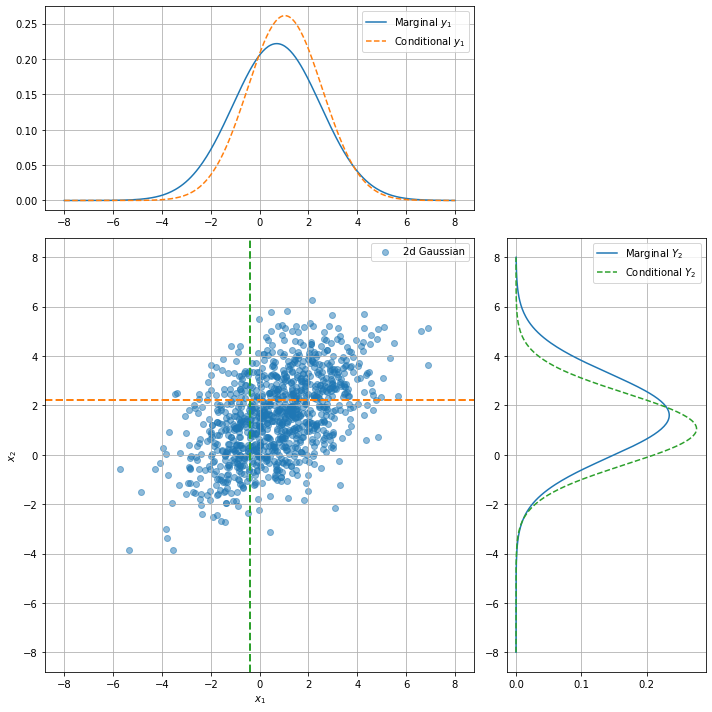

In [16]:
# Parameters for the 2D Gaussian distribution
mu1 = 0.7 
mu2 = 1.6 
sigma1 = 1.8 
sigma2 = 1.7 
rho = 0.529 
y1 = -0.4 
y2 = 2.2 

# Generate data points from the 2D Gaussian distribution
mu = jnp.array([mu1, mu2])
K = jnp.array([[sigma1**2, rho*sigma1*sigma2],[rho*sigma2*sigma1, sigma2**2]])
num_samples = 1000
data = np.random.multivariate_normal(mu, K, num_samples)

# Calculate marginal distributions
y_values = jnp.linspace(-8, 8, 300)

# compute marginals
normal1 = dist.Normal(loc=mu1, scale=sigma1)
normal2 = dist.Normal(loc=mu2, scale=sigma2)
density_x1 = jnp.exp(normal1.log_prob(y_values))
density_x2 = jnp.exp(normal2.log_prob(y_values))

# compute conditionals
cond_mu_x1, cond_sigma_x1 = Gaussian_conditional(mu, K, x=None, y=y2)
cond_mu_x2, cond_sigma_x2 = Gaussian_conditional(mu, K, x=y1, y=None)
cond_density_x1 = jnp.exp(dist.Normal(loc=cond_mu_x1, scale=cond_sigma_x1).log_prob(y_values))
cond_density_x2 = jnp.exp(dist.Normal(loc=cond_mu_x2, scale=cond_sigma_x2).log_prob(y_values))


# Create figure 
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 3)

# Main plot (2D Gaussian distribution)
ax_main = fig.add_subplot(gs[1:3, :2])
ax_main.scatter(data[:, 0], data[:, 1], alpha=0.5, label='2d Gaussian')
ax_main.set_xlabel('$x_1$')
ax_main.set_ylabel('$x_2$')
ax_main.axvline(y1, lw=2, c='C2', linestyle = '--')
ax_main.axhline(y2, lw=2, c='C1', linestyle = '--')
ax_main.legend()
ax_main.grid(True)

# Marginal x1 plot
ax_marginal_x = fig.add_subplot(gs[0, :2], sharex=ax_main)
ax_marginal_x.plot(y_values, density_x1, label='Marginal $y_1$')
ax_marginal_x.plot(y_values, cond_density_x1, label='Conditional $y_1$', linestyle = '--', c='C1')
ax_marginal_x.legend()
ax_marginal_x.grid(True)

# Marginal x2 plot
ax_marginal_y = fig.add_subplot(gs[1:3, 2], sharey=ax_main)
ax_marginal_y.plot(density_x2, y_values, label='Marginal $Y_2$' )
ax_marginal_y.plot(cond_density_x2, y_values, label='Conditional $Y_2$', linestyle='--', c='C2')
ax_marginal_y.legend()
ax_marginal_y.grid(True)

plt.tight_layout()
plt.show()

